### Optimizer
The optimizer evaluates the cost function to select the next set of parameters in a variational loop, and repeats the process until it reaches a stable state.

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

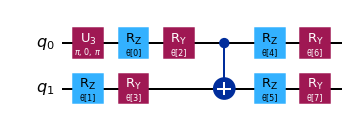

In [2]:
theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2, rotation_blocks=["rz", "ry"], entanglement_blocks="cx", entanglement="linear", reps=1
)

ansatz = reference_circuit.compose(variational_form)
ansatz.decompose().draw('mpl')

In [3]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

In [4]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

### Local Optimizers
Local optimizers search for a point that minimizes the cost function starting at initial points. They converge fast usually, but heaviliy dependent on the initial point and are vulnerable to local minima

In [6]:
from scipy.optimize import minimize

x0 = np.ones(8)
print(x0)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="SLSQP")

result

[1. 1. 1. 1. 1. 1. 1. 1.]


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.99999999645274
       x: [ 1.000e+00  1.000e+00 -1.571e+00 -4.556e-05 -1.207e+00
           -1.935e+00  4.079e-01 -4.079e-01]
     nit: 12
     jac: [ 1.192e-07  2.980e-08 -7.959e-04  2.543e-04  1.381e-03
            1.381e-03  5.431e-04  5.431e-04]
    nfev: 112
    njev: 12

### Global Optimizers
Its non-local, i.e. it searches for a point that minimizes the cost function over several regions of its domain. This takes time to converge, and is somewhat independent of initialization, but less susceptible to local minima.

### Bootstrapping Optimization
Here we set the initial value for parameters based on a prior optimization that helps us converge to our solution faster. 

### Gradient Based Optimizers
If we have a gradient of the function starting from the initial point, we update the parameters towards the direction of steepest descent of the function to minimize it. Main disadvantage is slow convergence, and no guarantee to achieve optimal solution

In [7]:
x0 = np.ones(8)
result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="BFGS")

In [8]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.999999999999782
        x: [ 1.000e+00  1.000e+00  1.571e+00  2.785e-07  2.009e-01
            -2.009e-01  6.342e-01 -6.342e-01]
      nit: 14
      jac: [ 5.960e-08 -2.980e-08  8.941e-07  1.013e-06  2.086e-07
             1.490e-07  5.960e-08  5.960e-08]
 hess_inv: [[ 1.000e+00 -2.999e-08 ... -7.780e-05 -6.011e-05]
            [-2.999e-08  1.000e+00 ... -3.475e-06 -7.574e-07]
            ...
            [-7.780e-05 -3.475e-06 ...  7.242e-01 -2.603e-01]
            [-6.011e-05 -7.574e-07 ... -2.603e-01  8.180e-01]]
     nfev: 144
     njev: 16

### Gradient-Free Optimizers
They are gradient free and tend to find global optima, wheras gradient-based methods tend to converge to local optima. However, gradient-free methods require higher computational resources.

In [9]:
x0 = np.ones(8)
result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9999999832448676
       x: [ 1.687e+00  1.250e+00  1.571e+00  3.142e+00  1.469e+00
           -1.672e+00  1.556e+00  1.585e+00]
    nfev: 126
   maxcv: 0.0

### Barren Plateau
Scenario where the cost landscape becomes progressively flatter, thus making it a challenge to determine the direction to the minimum

Area is still under research. Bootstrapping, experimenting with hardware-efficient ansatz, error suppression, and mitigation, and gradient free optimizers are recommended